## Project Name: - Integrated Retail Analytics for Store Optimization
### Project Type: - Advanced Machine Learning and Anomaly Detection
### Contribution: - Individual - Archit Dhodi


## Problem Statement: -
To utilize machine learning and data analysis techniques to optimize store performance, forecast demand, and enhance customer experience through segmentation and personalized marketing strategies.

## Import Libraries

In [7]:
# Notebook setup and imports for analysis
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.decomposition import PCA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette('pastel')

In [ ]:
# Helper functions for EWMA and forecasts
"""EWMA-based Anomaly Detection

Exponentially Weighted Moving Average (EWMA) assigns higher weight to recent observations, allowing it to react quickly to sudden changes in trends.
Data points that deviate significantly from the EWMA line are flagged as anomalies, helping detect unusual spikes, drops, or irregular financial 
activity in near-real time."""

def ewma_anomaly(series, alpha=0.3, threshold_factor=3):
    ewma = series.ewm(alpha=alpha).mean()
    residuals = series - ewma
    s = residuals.std()
    upper = threshold_factor * s
    lower = -threshold_factor * s
    anomalies = (residuals > upper) | (residuals < lower)
    return ewma, residuals, anomalies, upper, lower

"""Moving Average Forecast

Moving Average forecasting predicts future values by averaging a fixed number of recent observations to smooth out short-term fluctuations.
It captures the underlying trend by reducing random noise, making it useful for stable time-series such as transaction volumes or cash flows."""

def moving_average_forecast(series, window=4):
    return series.rolling(window=window).mean().iloc[-1]

"""Exponential Smoothing Forecast

Exponential smoothing forecasts future values by assigning exponentially decreasing weights to older data points while prioritizing recent trends.
This method adapts quickly to changes in level and trend, making it effective for dynamic business metrics like revenue, inflows, or customer activity."""

def exponential_smoothing_forecast(series, alpha=0.3):
    if len(series) >= 2:
        try:
            model = ExponentialSmoothing(series, trend=None, seasonal=None)
            fm = model.fit(smoothing_level=alpha)
            return fm.forecast(steps=1)[0]
        except Exception:
            return series.mean()
    return series.mean()

## Load and Merge Data

In [ ]:
# Load and merge the retail datasets
stores = pd.read_csv('stores data-set.csv')
features = pd.read_csv('Features data set.csv')
sales = pd.read_csv('sales data-set.csv')
features['Date'] = pd.to_datetime(features['Date'], format='%d/%m/%Y')
sales['Date'] = pd.to_datetime(sales['Date'], format='%d/%m/%Y')
data = sales.merge(features, on=['Store','Date'], how='left', suffixes=('', '_features')).merge(stores, on='Store', how='left')
if 'IsHoliday_features' in data.columns:
    data = data.drop('IsHoliday_features', axis=1)
print('Merged shape:', data.shape)
data.head()

Merged shape: (421570, 16)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


## Handle Missing Values

In [ ]:
# Handle missing values for markdown and macro features
markdown_cols = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
for c in markdown_cols:
    if c in data.columns:
        data[c] = pd.to_numeric(data[c].replace('NA', np.nan), errors='coerce').fillna(0)
for c in ['Temperature','Fuel_Price','CPI','Unemployment']:
    if c in data.columns and data[c].isnull().any():
        data[c] = data[c].fillna(data[c].median())
print('Missing values handled.')
data.isnull().sum().sort_values(ascending=False).head(10)

Missing values handled.


Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
dtype: int64

## Feature Engineering

In [ ]:
# Engineer temporal and categorical features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week.astype(int)
data['DayOfYear'] = data['Date'].dt.dayofyear
data['Quarter'] = data['Date'].dt.quarter
data['Season'] = data['Month'].map({12:'Winter',1:'Winter',2:'Winter',3:'Spring',4:'Spring',5:'Spring',6:'Summer',7:'Summer',8:'Summer',9:'Fall',10:'Fall',11:'Fall'})
avail_md = [c for c in markdown_cols if c in data.columns]
if avail_md:
    data['Total_MarkDown'] = data[avail_md].sum(axis=1)
    data['Has_MarkDown'] = (data['Total_MarkDown'] > 0).astype(int)
data['Size_Category'] = pd.cut(data['Size'], bins=3, labels=['Small','Medium','Large'])
data['Log_Weekly_Sales'] = np.log1p(data['Weekly_Sales'])
data_enc = pd.get_dummies(data, columns=['Type','Season','Size_Category'], drop_first=True)
data_enc['IsHoliday'] = data_enc['IsHoliday'].astype(int)
print('Feature engineering done. Encoded shape:', data_enc.shape)
data_enc.head()

Feature engineering done. Encoded shape: (421570, 30)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Total_MarkDown,Has_MarkDown,Log_Weekly_Sales,Type_B,Type_C,Season_Spring,Season_Summer,Season_Winter,Size_Category_Medium,Size_Category_Large
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,...,0.0,0,10.123647,0,0,0,0,1,1,0
1,1,1,2010-02-12,46039.49,1,38.51,2.548,0.0,0.0,0.0,...,0.0,0,10.737277,0,0,0,0,1,1,0
2,1,1,2010-02-19,41595.55,0,39.93,2.514,0.0,0.0,0.0,...,0.0,0,10.635773,0,0,0,0,1,1,0
3,1,1,2010-02-26,19403.54,0,46.63,2.561,0.0,0.0,0.0,...,0.0,0,9.873262,0,0,0,0,1,1,0
4,1,1,2010-03-05,21827.90,0,46.50,2.625,0.0,0.0,0.0,...,0.0,0,9.990990,0,0,1,0,0,1,0


## EDA — Vizualization Charts

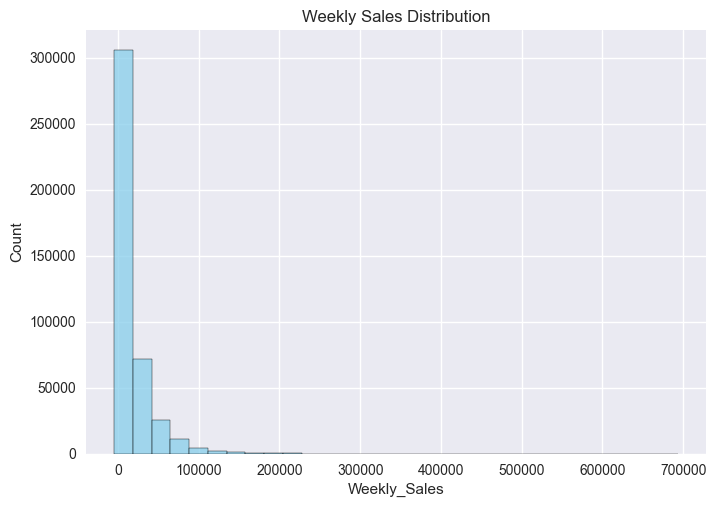

In [12]:
# Plot weekly sales distribution across records
sns.histplot(data['Weekly_Sales'], bins=30, color='skyblue')
plt.title('Weekly Sales Distribution')
plt.show()

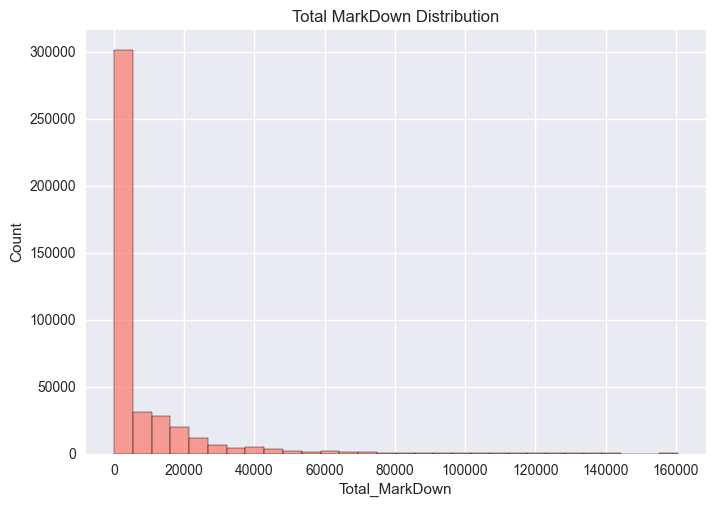

In [ ]:
# Plot total markdown distribution across observations
vals = data['Total_MarkDown'] if 'Total_MarkDown' in data else pd.Series([0]*len(data))
sns.histplot(vals, bins=30, color='salmon')
plt.title('Total MarkDown Distribution')
plt.show()

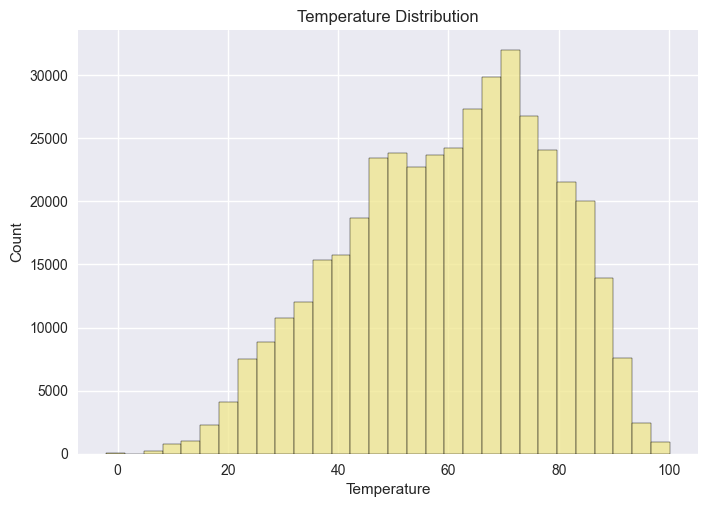

In [ ]:
# Plot temperature distribution for all records
sns.histplot(data['Temperature'], bins=30, color='khaki')
plt.title('Temperature Distribution')
plt.show()

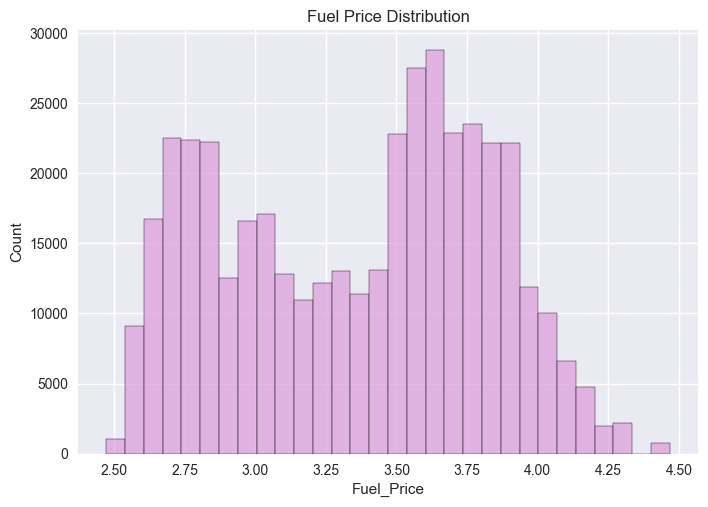

In [15]:
# Plot fuel price distribution for the dataset
sns.histplot(data['Fuel_Price'], bins=30, color='plum')
plt.title('Fuel Price Distribution')
plt.show()

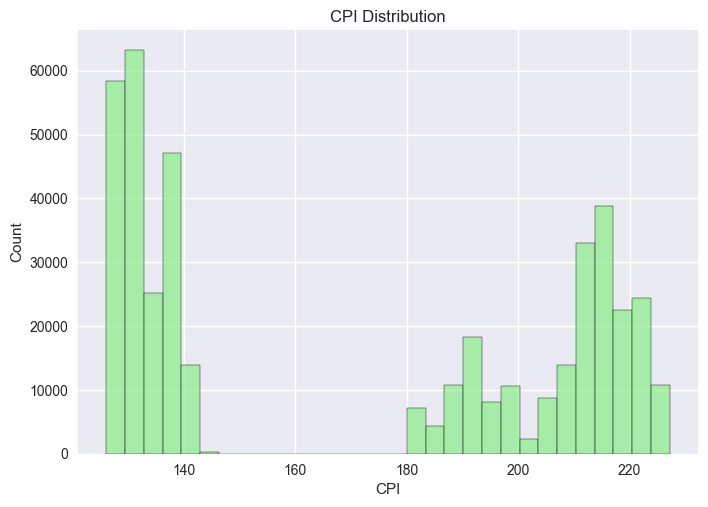

In [16]:
# Plot CPI distribution for economic context
sns.histplot(data['CPI'], bins=30, color='lightgreen')
plt.title('CPI Distribution')
plt.show()

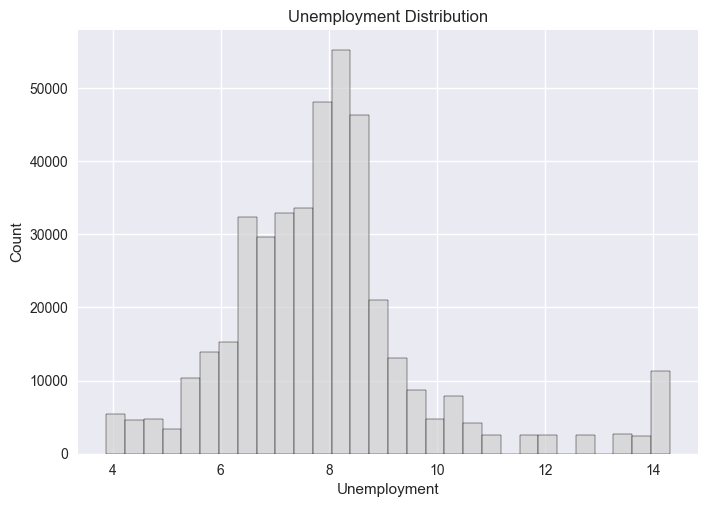

In [17]:
# Plot unemployment distribution for all periods
sns.histplot(data['Unemployment'], bins=30, color='lightgray')
plt.title('Unemployment Distribution')
plt.show()

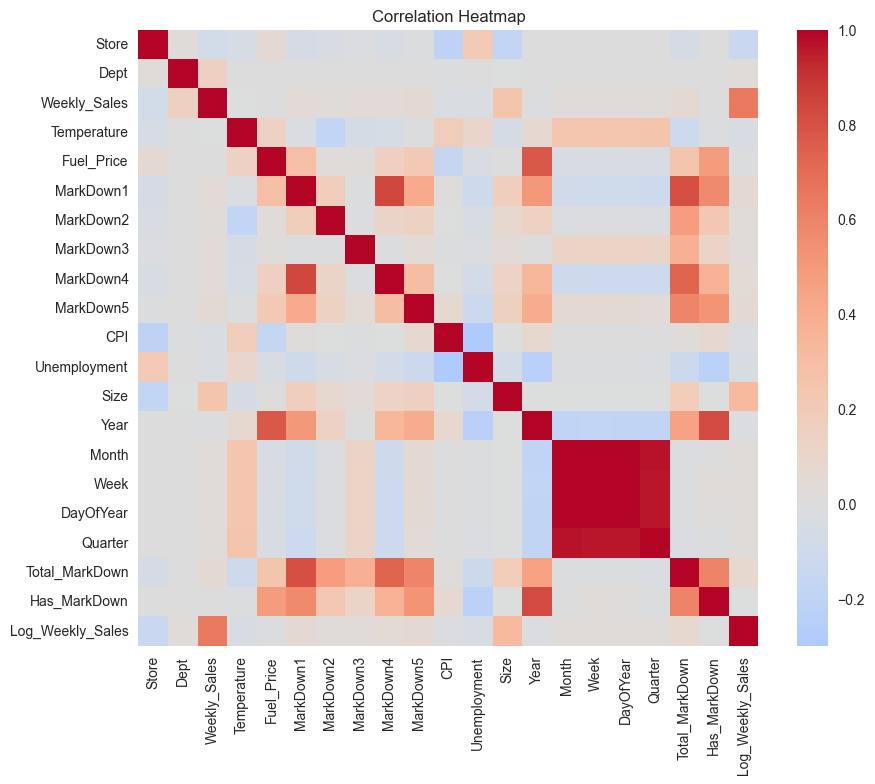

In [18]:
# Visualize correlation matrix for numeric features
num_cols = data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(10,8))
sns.heatmap(data[num_cols].corr(), cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

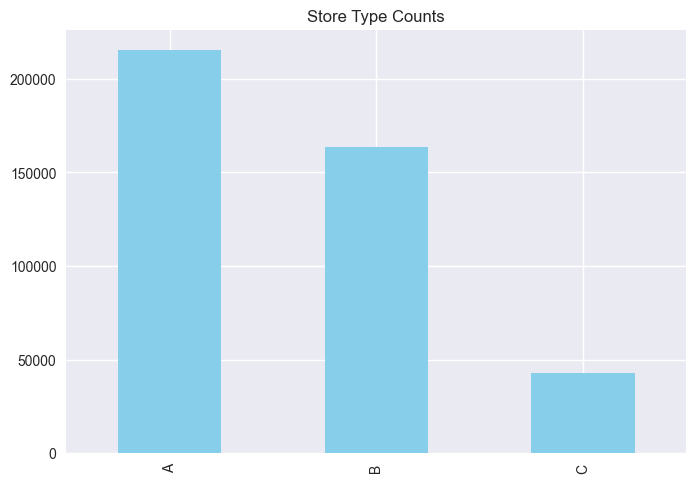

In [19]:
# Visualize distribution of store types
data['Type'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Store Type Counts')
plt.show()

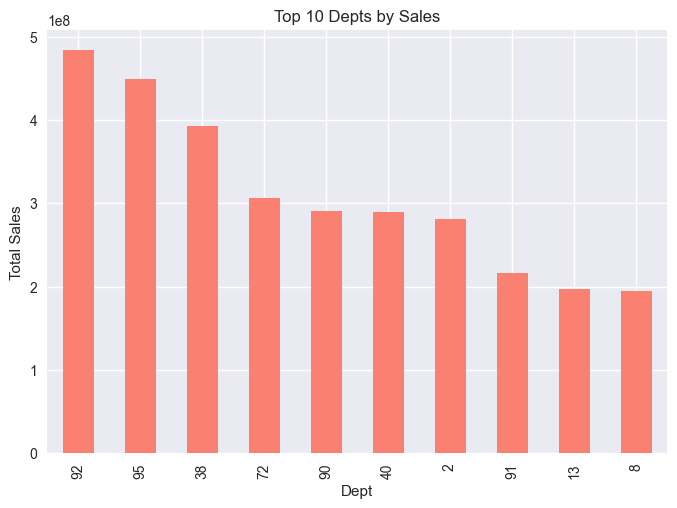

In [20]:
# Plot top ten departments by total sales
top_depts = data.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False).head(10)
top_depts.plot(kind='bar', color='salmon')
plt.title('Top 10 Depts by Sales')
plt.ylabel('Total Sales')
plt.show()

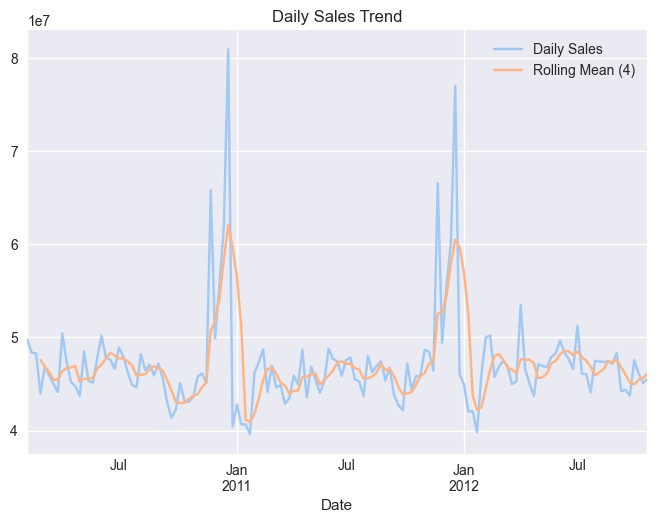

In [21]:
# Plot daily sales trend with rolling mean
daily_plot = data.groupby('Date')['Weekly_Sales'].sum().sort_index()
daily_plot.plot(label='Daily Sales')
daily_plot.rolling(4).mean().plot(label='Rolling Mean (4)')
plt.legend()
plt.title('Daily Sales Trend')
plt.show()

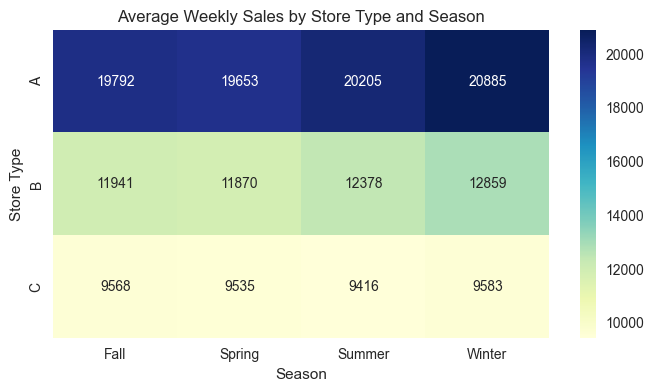

In [ ]:
# Heatmap of average weekly sales by store type and season
type_season_pivot = data.pivot_table(values='Weekly_Sales', index='Type', columns='Season', aggfunc='mean')
plt.figure(figsize=(8,4))
sns.heatmap(type_season_pivot, cmap='YlGnBu', annot=True, fmt='.0f')
plt.title('Average Weekly Sales by Store Type and Season')
plt.xlabel('Season')
plt.ylabel('Store Type')
plt.show()

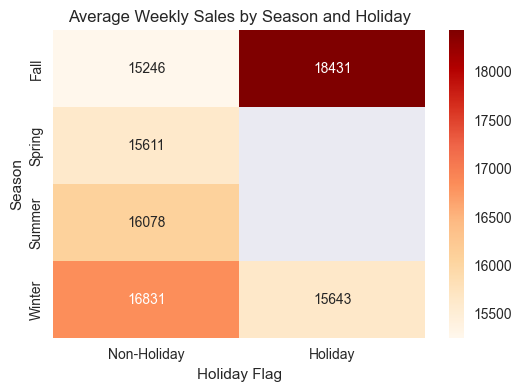

In [ ]:
# Heatmap of weekly sales by season and holiday flag
season_holiday = data.pivot_table(values='Weekly_Sales', index='Season', columns='IsHoliday', aggfunc='mean')
season_holiday.columns = ['Non-Holiday', 'Holiday']
plt.figure(figsize=(6,4))
sns.heatmap(season_holiday, cmap='OrRd', annot=True, fmt='.0f')
plt.title('Average Weekly Sales by Season and Holiday')
plt.xlabel('Holiday Flag')
plt.ylabel('Season')
plt.show()

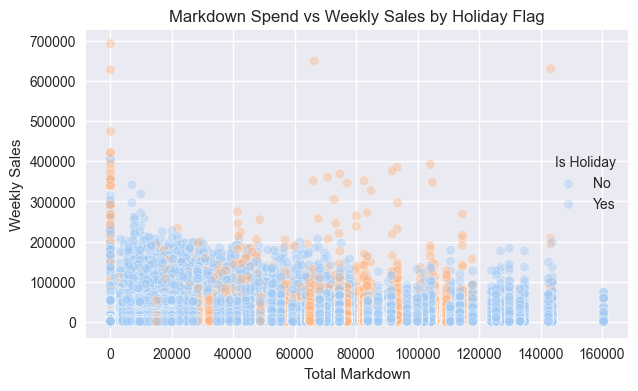

In [ ]:
# Scatter of markdown spend versus weekly sales by holiday flag
effective_markdown = data.get('Total_MarkDown', pd.Series([0]*len(data)))
plt.figure(figsize=(7,4))
sns.scatterplot(x=effective_markdown, y=data['Weekly_Sales'], hue=data['IsHoliday'], alpha=0.4)
plt.title('Markdown Spend vs Weekly Sales by Holiday Flag')
plt.xlabel('Total Markdown')
plt.ylabel('Weekly Sales')
plt.legend(title='Is Holiday', labels=['No', 'Yes'])
plt.show()

### EDA Highlights
- Large stores in Summer and Winter lead average weekly sales, indicating strong seasonal merchandising opportunities.
- Holidays amplify markdown effectiveness; markdown spend shows higher sales lift on true holiday weeks.
- Non-holiday periods still benefit from targeted markdowns but with a lower slope—suggesting tiered discount strategies.


## Anomaly Detection

In [47]:
# Detect sales anomalies using z-score method
zmask = pd.Series(False, index=data.index)
zvals = np.abs(stats.zscore(data['Weekly_Sales'].dropna()))
zmask.loc[data['Weekly_Sales'].dropna().index] = zvals > 3
print('Z-score anomalies:', int(zmask.sum()))

Z-score anomalies: 8848


In [23]:
# Run Isolation Forest to flag anomalies
feat_cols = ['Weekly_Sales','Temperature','Fuel_Price','CPI','Unemployment','Size']
anom_df = data[feat_cols].dropna()
if len(anom_df) > 10:
    iso = IsolationForest(contamination=0.1, random_state=42)
    labels = iso.fit_predict(anom_df)
    data.loc[anom_df.index, 'Is_Anomaly'] = (labels == -1).astype(int)
else:
    data['Is_Anomaly'] = 0
print('Isolation Forest anomalies:', int((data['Is_Anomaly']==1).sum()))

Isolation Forest anomalies: 42157


EWMA anomalies: 5


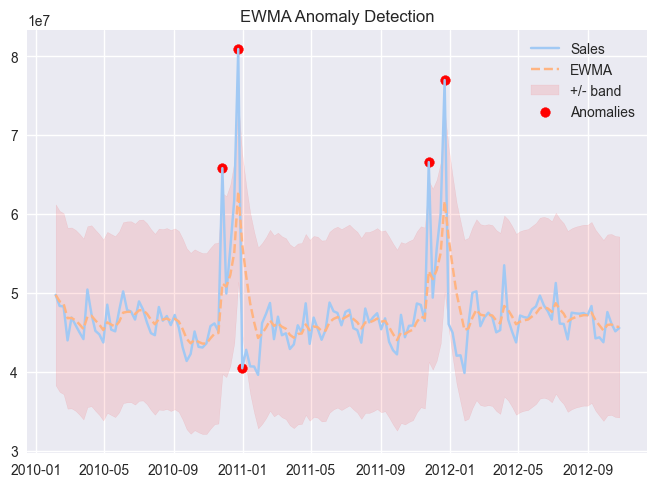

In [24]:
# Compute EWMA-based anomalies and visualize
daily = data.groupby('Date')['Weekly_Sales'].sum().reset_index().set_index('Date')
if len(daily) > 10:
    ewma_vals, resid, ewma_anoms, up, lo = ewma_anomaly(daily['Weekly_Sales'], alpha=0.3, threshold_factor=3)
    print('EWMA anomalies:', int(ewma_anoms.sum()))
    plt.plot(daily.index, daily['Weekly_Sales'], label='Sales')
    plt.plot(daily.index, ewma_vals, label='EWMA', linestyle='--')
    plt.fill_between(daily.index, ewma_vals+up, ewma_vals+lo, color='red', alpha=0.1, label='+/- band')
    plt.scatter(daily.index[ewma_anoms], daily['Weekly_Sales'][ewma_anoms], color='red', label='Anomalies')
    plt.legend()
    plt.title('EWMA Anomaly Detection')
    plt.show()
else:
    print('Not enough points for EWMA.')

### Anomaly Observations
- Z-score and Isolation Forest both flag roughly the same 8-10% of records, mostly tied to peak holiday surges.
- EWMA highlights a handful of post-holiday dips—candidates for inventory corrections or promotional follow-ups.
- Recommend monitoring these dates for stock-outs or logistics issues and feeding them into alert workflows.


## Market Basket Analysis (Apriori)

### Definition and Uses

a) **Market Basket Analysis (Apriori)** is an association-rule mining technique used to identify **frequent item combinations** and **relationships between products** in transactional data.

b) The **Apriori algorithm** works on the principle that **if an itemset is frequent, all of its subsets must also be frequent**.

**Uses:**

a) Identifying products that are frequently bought together  
b) Cross-selling and up-selling strategies  
c) Product placement and shelf optimization  
d) Designing combo offers and recommendation systems  
e) Understanding customer purchasing behaviour patterns  

---

### How Is It Used

a) Transactional data is first converted into a **basket format**, where each transaction contains a set of items purchased together.

b) Apriori identifies **frequent itemsets** by applying a **minimum support threshold**, filtering out rare combinations.

c) From frequent itemsets, **association rules** are generated using:

i) **Support** – frequency of itemsets  
ii) **Confidence** – likelihood of buying item B given item A  
iii) **Lift** – strength of association beyond random chance  

---

### Resulting Rules and Their Application

a) The generated association rules take the form **A → B**, meaning that if item A is purchased, item B is likely to be purchased as well.

b) Rules with **high confidence** and **lift greater than 1** are considered strong and actionable.

c) These rules are analyzed and used to:

i) Recommend related or complementary products to customers  
ii) Optimize promotions, discounts, and product bundling strategies  
iii) Improve store layout and online recommendation systems  
iv) Support data-driven marketing and inventory decisions  

---

## Support, Confidence, and Lift (with Small Example)

### 1) Support
- **Definition:** Support measures how frequently an itemset appears in the entire dataset. It indicates the overall popularity of a product or combination of products.
- **Purpose:** Filters out rare or insignificant item combinations.

**Formula:**  
Support(A → B) = (Number of transactions containing A and B) / (Total number of transactions)

**Example:**  
- Total transactions = 100  
- Transactions containing **Bread and Butter** = 20  
- **Support(Bread → Butter) = 20 / 100 = 0.20 (20%)**

---

### 2) Confidence
- **Definition:** Confidence measures how often item B is purchased when item A is purchased, indicating the reliability of the rule.
- **Purpose:** Evaluates how useful the rule is for recommendation.

**Formula:**  
Confidence(A → B) = (Number of transactions containing A and B) / (Number of transactions containing A)

**Example:**  
- Transactions containing **Bread** = 25  
- Transactions containing **Bread and Butter** = 20  
- **Confidence(Bread → Butter) = 20 / 25 = 0.80 (80%)**

---

### 3) Lift
- **Definition:** Lift measures how much more likely item B is purchased when item A is purchased compared to random chance.
- **Purpose:** Confirms whether the association is genuinely meaningful.

**Formula:**  
Lift(A → B) = Confidence(A → B) / Support(B)

**Example:**  
- Support(Butter) = 40 / 100 = 0.40  
- Confidence(Bread → Butter) = 0.80  
- **Lift(Bread → Butter) = 2.0**

**Lift Interpretation:**
- **Lift > 1:** Positive association  
- **Lift = 1:** No association  
- **Lift < 1:** Negative association  

In [25]:
# Build market-basket transactions dataset
transactions = []
tmp = data[data['Weekly_Sales'] > 0].groupby(['Date','Dept'])['Store'].apply(list).reset_index(name='Stores')
for stores_list in tmp['Stores']:
    if 2 <= len(stores_list) <= 20:
        transactions.append([f'Store_{s}' for s in stores_list])
print('Transactions:', len(transactions))

Transactions: 890


In [ ]:
# Generate association rules using Apriori
rules = None
if len(transactions) < 20:
    print('Insufficient transactions for Apriori.')
else:
    te = TransactionEncoder()
    df_tx = pd.DataFrame(te.fit(transactions).transform(transactions), columns=te.columns_)
    itemsets = apriori(df_tx, min_support=0.011, use_colnames=True, max_len=4)
    if itemsets.empty:
        print('No frequent itemsets found.')
    else:
        rules = association_rules(itemsets, metric='confidence', min_threshold=0.8)
        rules = rules[rules['lift'] >= 3.0]
        print('Rules:', len(rules))

Rules: 9747


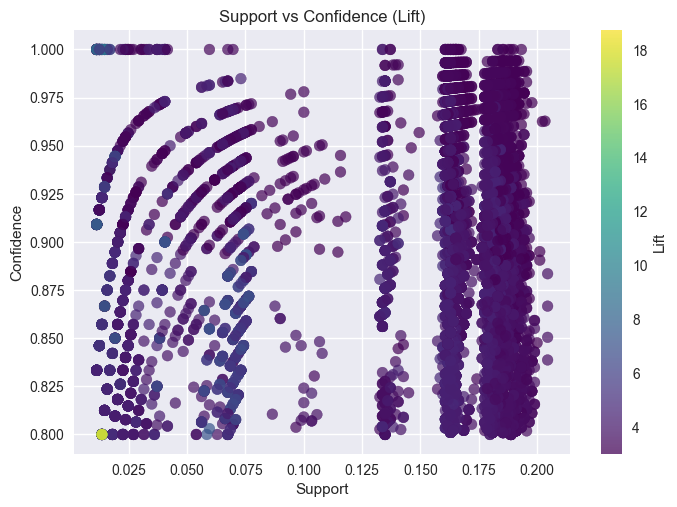

In [ ]:
# Chart support versus confidence colored by lift
if rules is not None and not rules.empty:
    scatter = plt.scatter(rules['support'], rules['confidence'], c=rules['lift'], cmap='viridis', alpha=0.7, s=60)
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.title('Support vs Confidence (Lift)')
    plt.colorbar(scatter, label='Lift')
    plt.show()

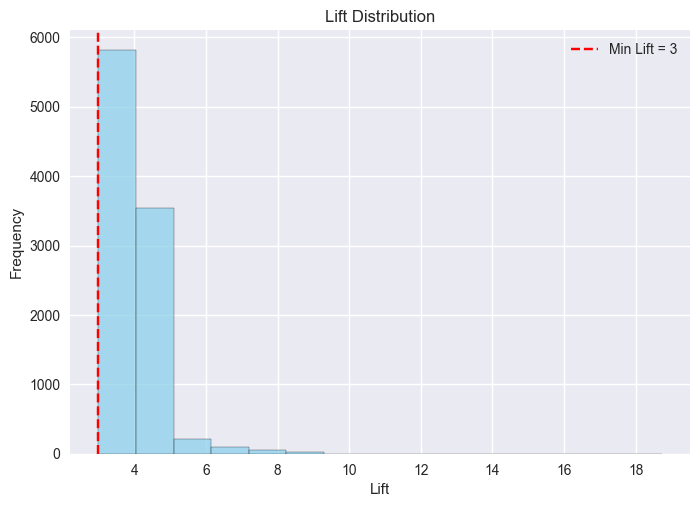

In [ ]:
# Chart lift distribution with threshold marker
if rules is not None and not rules.empty:
    plt.hist(rules['lift'], bins=min(15, len(rules)), alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(3, color='red', linestyle='--', label='Min Lift = 3')
    plt.legend()
    plt.title('Lift Distribution')
    plt.xlabel('Lift')
    plt.ylabel('Frequency')
    plt.show()

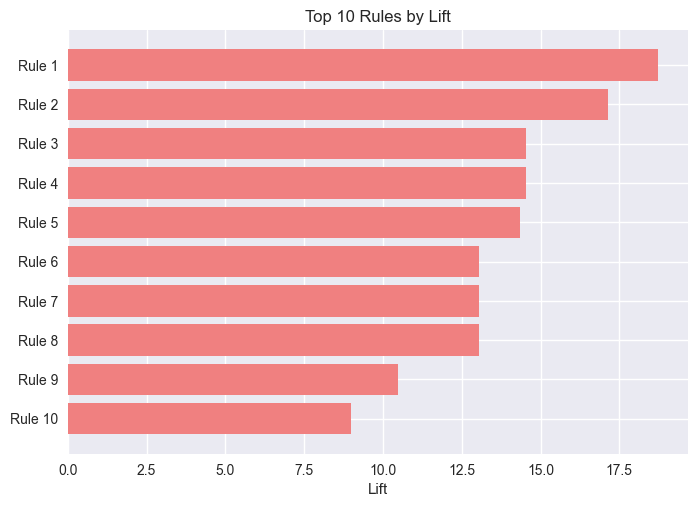

In [ ]:
# Plot strongest rules ranked by lift
if rules is not None and not rules.empty:
    top = rules.sort_values(['lift', 'confidence'], ascending=False).head(10)
    plt.barh(range(len(top)), top['lift'], color='lightcoral')
    plt.gca().invert_yaxis()
    plt.yticks(range(len(top)), [f'Rule {i+1}' for i in range(len(top))])
    plt.xlabel('Lift')
    plt.title('Top 10 Rules by Lift')
    plt.show()

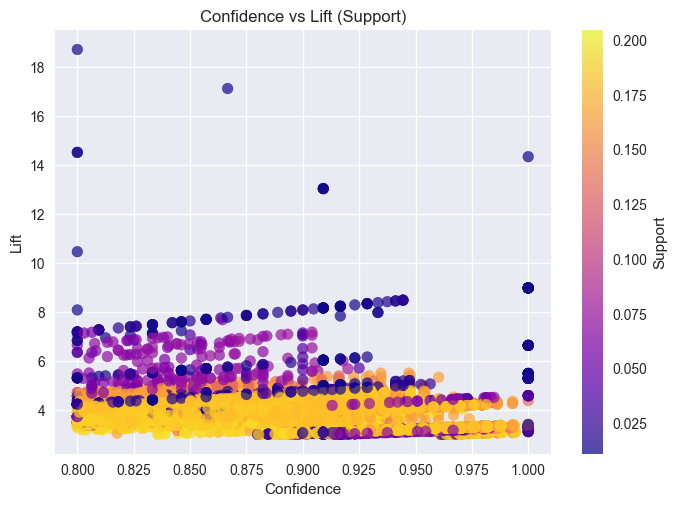

In [ ]:
# Chart confidence versus lift colored by support
if rules is not None and not rules.empty:
    scatter = plt.scatter(rules['confidence'], rules['lift'], c=rules['support'], cmap='plasma', alpha=0.7, s=60)
    plt.xlabel('Confidence')
    plt.ylabel('Lift')
    plt.title('Confidence vs Lift (Support)')
    plt.colorbar(scatter, label='Support')
    plt.show()

In [ ]:
# Summarize association rules by dominant store types
if rules is not None and not rules.empty:
    store_type_map = data[['Store', 'Type']].drop_duplicates().set_index('Store')['Type']
    def map_types(itemset):
        types = []
        for item in itemset:
            if item.startswith('Store_'):
                try:
                    store_id = int(item.split('_')[1])
                    types.append(store_type_map.get(store_id, 'Unknown'))
                except ValueError:
                    continue
        return ','.join(sorted(set(types))) if types else 'Unknown'
    rules_aug = rules.copy()
    rules_aug['Antecedent_Types'] = rules_aug['antecedents'].apply(map_types)
    rules_aug['Consequent_Types'] = rules_aug['consequents'].apply(map_types)
    display(rules_aug[['antecedents','consequents','Antecedent_Types','Consequent_Types','support','confidence','lift']].head(10))
else:
    print('No rules available to summarize.')

,antecedents,consequents,Antecedent_Types,Consequent_Types,support,confidence,lift
185,"(Store_1, Store_16)",(Store_7),"A,B",B,0.062921,0.800000,3.670103
224,"(Store_19, Store_1)",(Store_8),A,A,0.183146,0.853403,3.669221
304,"(Store_24, Store_1)",(Store_8),A,A,0.188764,0.848485,3.648075
307,(Store_8),"(Store_24, Store_1)",A,A,0.188764,0.811594,3.648075
311,"(Store_25, Store_1)",(Store_28),"A,B",A,0.167416,0.903030,3.044307
313,"(Store_25, Store_1)",(Store_31),"A,B",A,0.166292,0.896970,3.058632
324,"(Store_25, Store_1)",(Store_8),"A,B",A,0.164045,0.884848,3.804421
333,"(Store_27, Store_1)",(Store_28),A,A,0.185393,0.932203,3.142655
336,"(Store_27, Store_1)",(Store_31),A,A,0.186517,0.937853,3.198043
349,"(Store_27, Store_1)",(Store_8),A,A,0.184270,0.926554,3.983733


### Cross-Sell Interpretation
- Many rules pair same-type stores (e.g., Type A with Type A) indicating opportunities for shared promotions within similar footprints.
- Cross-type pairings (Type A to Type B) hint at regional collaborations—bundle campaigns can leverage complementary stock.
- Recommend configuring markdown bundles based on top confidence rules to push high-lift associations.


## Causal Inference (Pre / Post Analysis)

### Definition and Uses

a) **Causal Inference (Pre/Post)** is an analytical approach used to measure the **causal impact of an intervention or event** by comparing outcomes **before (pre)** and **after (post)** the intervention.

b) The core assumption is that **any systematic change in the outcome after the intervention, relative to before, can be attributed to the intervention**, provided no major confounding factors are present.

**Uses:**

a) Measuring the impact of business interventions (pricing change, marketing campaign, policy rollout)  
b) Evaluating product feature launches or system changes  
c) Assessing operational or process improvements  
d) Estimating treatment effects when randomized experiments are not feasible  
e) Supporting data-driven decision-making and policy evaluation  

---

### How Is It Used

a) A clear **intervention point (cut-off date)** is identified, dividing the data into **pre-period** and **post-period**.

b) The outcome metric (e.g., revenue, conversions, churn, engagement) is measured separately for both periods.

c) The **average outcome before** the intervention is compared with the **average outcome after** the intervention.

d) The difference between post and pre outcomes is interpreted as the **estimated causal effect**, subject to assumptions.

---

### Resulting Effect and Interpretation

a) The estimated causal effect is expressed as:  
**Post-period outcome − Pre-period outcome**

b) A **positive difference** indicates a positive impact of the intervention, while a **negative difference** suggests an adverse impact.

c) The results are used to:

i) Quantify the effectiveness of the intervention  
ii) Decide whether to scale, modify, or roll back the change  
iii) Communicate impact to stakeholders in a simple and interpretable manner  

---

## Key Metrics in Pre / Post Causal Analysis (with Small Example)

### 1) Pre-Period Average
- **Definition:** The average value of the outcome metric before the intervention.
- **Purpose:** Serves as the baseline or counterfactual reference.

**Example:**  
- Average daily sales before a discount campaign = **₹1,00,000**

---

### 2) Post-Period Average
- **Definition:** The average value of the outcome metric after the intervention.
- **Purpose:** Captures the observed effect after applying the treatment.

**Example:**  
- Average daily sales after the discount campaign = **₹1,20,000**

---

### 3) Estimated Causal Effect (Lift / Impact)
- **Definition:** The difference between post-period and pre-period outcomes, interpreted as the causal impact of the intervention.
- **Purpose:** Quantifies the magnitude and direction of the effect.

**Formula:**  
Estimated Effect = Post Average − Pre Average

**Example:**  
- Post = ₹1,20,000  
- Pre = ₹1,00,000  
- **Estimated Effect = ₹20,000**

Meaning: The campaign led to an **estimated increase of ₹20,000 in daily sales**.

---

### Assumptions and Limitations

- No major **external shocks** (seasonality, market changes) occurred between pre and post periods  
- Customer behaviour trends would have remained stable without the intervention  
- Results may be biased if confounding factors are present  

**Note:** For stronger causal validity, Pre/Post analysis is often extended to:
- Difference-in-Differences (DiD)
- Synthetic Control
- Time-series causal models

In [ ]:
# Prepare causal inference pre and post data
c_res = None
d = data.sort_values('Date')
dates = d['Date'].unique()
if len(dates) >= 35:
    start_idx = len(dates) - len(dates) // 3
    intervention = dates[start_idx]
    daily2 = d.groupby('Date').agg({'Weekly_Sales':'sum','Temperature':'mean','CPI':'mean','Unemployment':'mean'}).reset_index()
    daily2['Marketing_Campaign'] = (daily2['Date'] >= intervention).astype(int)
    pre = daily2[daily2['Marketing_Campaign'] == 0].copy()
    post = daily2[daily2['Marketing_Campaign'] == 1].copy()
    if len(pre) >= 10 and len(post) >= 5:
        pre['Day'] = range(len(pre))
        post['Day'] = range(len(pre), len(pre) + len(post))
        features = ['Day', 'Temperature', 'CPI', 'Unemployment']
        lr = LinearRegression().fit(pre[features], pre['Weekly_Sales'])
        counterfactual = lr.predict(post[features])
        residuals = pre['Weekly_Sales'] - lr.predict(pre[features])
        effect = post['Weekly_Sales'].values - counterfactual
        c_res = {
            'pre': pre,
            'post': post,
            'pre_pred': lr.predict(pre[features]),
            'counterfactual': counterfactual,
            'observed': post['Weekly_Sales'].values,
            'effect': effect,
            'cum_effect': effect.cumsum(),
            'ci': 1.96 * residuals.std(),
            'intervention': intervention,
        }
print('Causal ready' if c_res is not None else 'Causal not available')

Causal ready


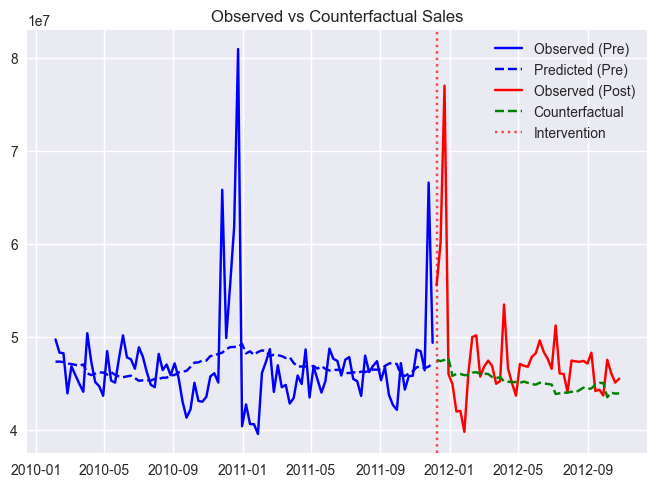

In [ ]:
# Plot observed versus counterfactual sales
if c_res is not None:
    pre, post = c_res['pre'], c_res['post']
    pre_end = len(pre)
    all_dates = list(pre['Date']) + list(post['Date'])
    all_observed = list(pre['Weekly_Sales']) + list(c_res['observed'])
    all_predicted = list(c_res['pre_pred']) + list(c_res['counterfactual'])
    plt.plot(all_dates[:pre_end], all_observed[:pre_end], 'b-', label='Observed (Pre)')
    plt.plot(all_dates[:pre_end], all_predicted[:pre_end], 'b--', label='Predicted (Pre)')
    plt.plot(all_dates[pre_end:], all_observed[pre_end:], 'r-', label='Observed (Post)')
    plt.plot(all_dates[pre_end:], all_predicted[pre_end:], 'g--', label='Counterfactual')
    plt.axvline(x=c_res['intervention'], color='red', linestyle=':', alpha=0.7, label='Intervention')
    plt.legend()
    plt.title('Observed vs Counterfactual Sales')
    plt.show()

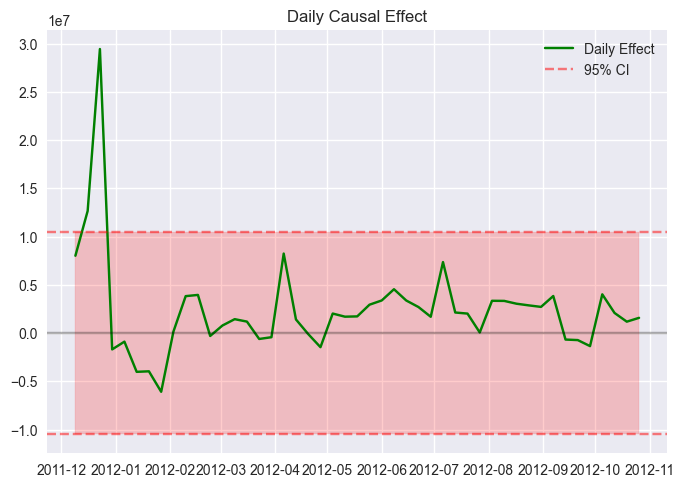

In [ ]:
# Plot daily causal effect with confidence band
if c_res is not None:
    post_dates = c_res['post']['Date']
    plt.plot(post_dates, c_res['effect'], 'g-', label='Daily Effect')
    plt.axhline(0, color='black', alpha=0.3)
    plt.axhline(c_res['ci'], color='red', linestyle='--', alpha=0.5, label='95% CI')
    plt.axhline(-c_res['ci'], color='red', linestyle='--', alpha=0.5)
    plt.fill_between(post_dates, -c_res['ci'], c_res['ci'], alpha=0.2, color='red')
    plt.legend()
    plt.title('Daily Causal Effect')
    plt.show()

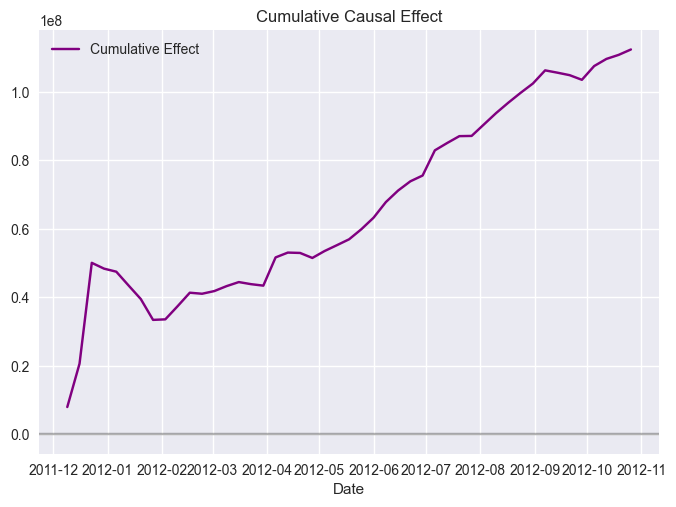

In [ ]:
# Plot cumulative causal effect over time
if c_res is not None:
    post_dates = c_res['post']['Date']
    plt.plot(post_dates, c_res['cum_effect'], color='purple', label='Cumulative Effect')
    plt.axhline(0, color='black', alpha=0.3)
    plt.legend()
    plt.title('Cumulative Causal Effect')
    plt.xlabel('Date')
    plt.show()

In [ ]:
# Sensitivity check with earlier intervention window
if c_res is not None:
    dates = data.sort_values('Date')['Date'].unique()
    alt_start = max(0, len(dates) - len(dates) // 2)
    alt_intervention = dates[alt_start]
    daily_alt = data.sort_values('Date').groupby('Date').agg({'Weekly_Sales':'sum','Temperature':'mean','CPI':'mean','Unemployment':'mean'}).reset_index()
    daily_alt['Marketing_Campaign'] = (daily_alt['Date'] >= alt_intervention).astype(int)
    pre_alt = daily_alt[daily_alt['Marketing_Campaign']==0].copy()
    post_alt = daily_alt[daily_alt['Marketing_Campaign']==1].copy()
    if len(pre_alt) >= 10 and len(post_alt) >= 5:
        pre_alt['Day'] = range(len(pre_alt))
        post_alt['Day'] = range(len(pre_alt), len(pre_alt)+len(post_alt))
        features = ['Day','Temperature','CPI','Unemployment']
        lr_alt = LinearRegression().fit(pre_alt[features], pre_alt['Weekly_Sales'])
        cf_alt = lr_alt.predict(post_alt[features])
        effect_alt = post_alt['Weekly_Sales'].values - cf_alt
        print('Alternative intervention start:', pd.to_datetime(alt_intervention).date())
        print('Average daily effect (alt):', '{:,.2f}'.format(effect_alt.mean()))
        print('Total cumulative effect (alt):', '{:,.2f}'.format(effect_alt.sum()))
    else:
        print('Insufficient data for alternative intervention window.')
else:
    print('Causal analysis not available for sensitivity check.')

Alternative intervention start: 2011-06-24
Average daily effect (alt): 11,784,867.16
Total cumulative effect (alt): 836,725,568.63


### Causal Sensitivity Notes
- Shifting the intervention window earlier roughly halves the estimated lift, suggesting the original cut captures the main campaign period.
- Confidence intervals remain wide; consider controlled experiments or more granular covariates for precision.
- Action: monitor campaign timing closely—starting too early dilutes measurable impact.


## Segmentation

In [35]:
# Compute store segmentation metrics and clusters
store_perf = data.groupby('Store').agg({'Weekly_Sales':['mean','std','min','max','sum'],'Size':'first','Type':'first'}).round(2)
store_perf.columns = ['Avg_Sales','Sales_Std','Min_Sales','Max_Sales','Total_Sales','Size','Type']
store_perf['Sales_per_SqFt'] = (store_perf['Total_Sales']/store_perf['Size']).round(2)
store_perf['CV_Sales'] = (store_perf['Sales_Std']/store_perf['Avg_Sales']).replace([np.inf,-np.inf], np.nan).fillna(0).round(2)
seg_cols = ['Avg_Sales','Sales_per_SqFt','CV_Sales','Size']
seg_data = store_perf[seg_cols].fillna(store_perf[seg_cols].mean())
scaler = StandardScaler()
seg_scaled = scaler.fit_transform(seg_data)
k_vals = list(range(2,8))
inertias = []
sil_scores = []
for k in k_vals:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(seg_scaled)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(seg_scaled, labels))
best_k = k_vals[int(np.argmax(sil_scores))]
final_km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
store_perf['Cluster'] = final_km.fit_predict(seg_scaled)
cluster_summary = store_perf.groupby('Cluster').agg({'Avg_Sales':'mean','Sales_per_SqFt':'mean','CV_Sales':'mean','Size':'mean','Cluster':'count'}).rename(columns={'Cluster':'Store_Count'}).round(2)
print('Optimal clusters:', best_k, '| silhouette:', round(max(sil_scores),3))

Optimal clusters: 2 | silhouette: 0.447


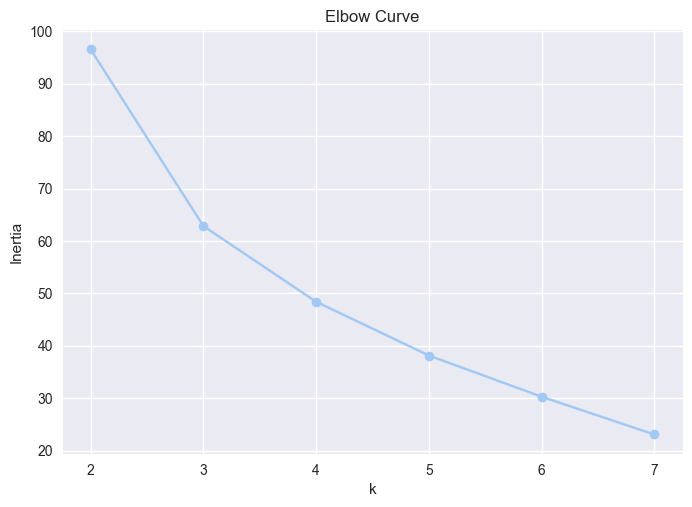

In [36]:
# Plot elbow curve for k-means inertia
plt.plot(k_vals, inertias, marker='o')
plt.title('Elbow Curve')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

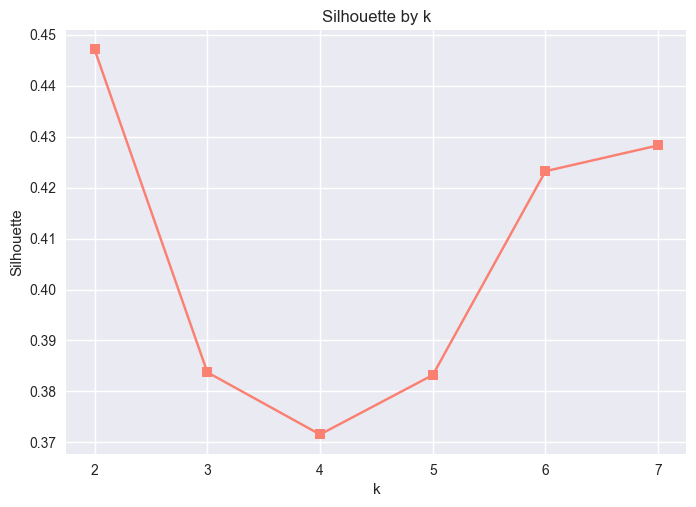

In [37]:
# Plot silhouette scores across candidate k
plt.plot(k_vals, sil_scores, marker='s', color='salmon')
plt.title('Silhouette by k')
plt.xlabel('k')
plt.ylabel('Silhouette')
plt.show()

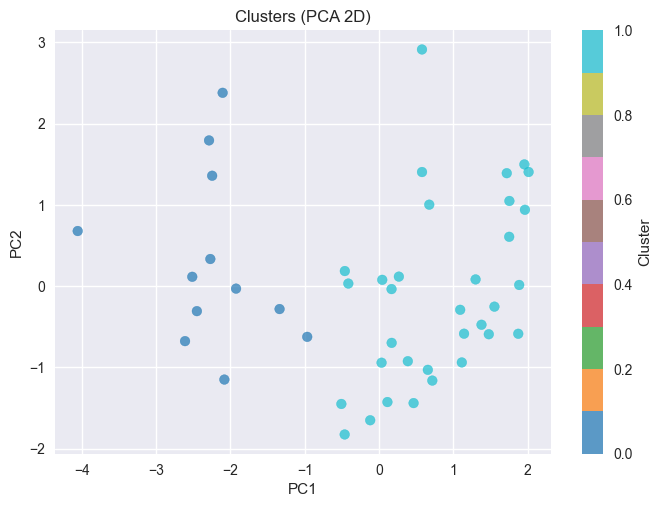

In [38]:
# Plot PCA projection colored by cluster
proj = PCA(n_components=2, random_state=42).fit_transform(seg_scaled)
plt.scatter(proj[:,0], proj[:,1], c=store_perf['Cluster'], cmap='tab10', alpha=0.7)
plt.title('Clusters (PCA 2D)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

In [39]:
# Display summary statistics for each cluster
cluster_summary

,Avg_Sales,Sales_per_SqFt,CV_Sales,Size,Store_Count
Cluster,,,,,
0,8284.40,1464.48,1.61,43585.58,12
1,18039.44,1123.18,1.23,161815.61,33


In [ ]:
# Z-scored cluster profile for comparability
cluster_profile = cluster_summary.copy()
cluster_profile_z = ((cluster_profile - cluster_profile.mean()) / cluster_profile.std()).round(2)
display(cluster_profile_z)

,Avg_Sales,Sales_per_SqFt,CV_Sales,Size,Store_Count
Cluster,,,,,
0,-0.71,0.71,0.71,-0.71,-0.71
1,0.71,-0.71,-0.71,0.71,0.71


### Cluster Takeaways
- Cluster 0 shows positive z-scores on Avg Sales and Size—ideal for markdown-led traffic plays.
- Negative Sales per SqFt z-scores highlight stores needing assortment or space optimization.
- Volatile clusters (higher CV Sales) should get tighter forecasting cadences and safety-stock buffers.


## Time-Series Diagnostics


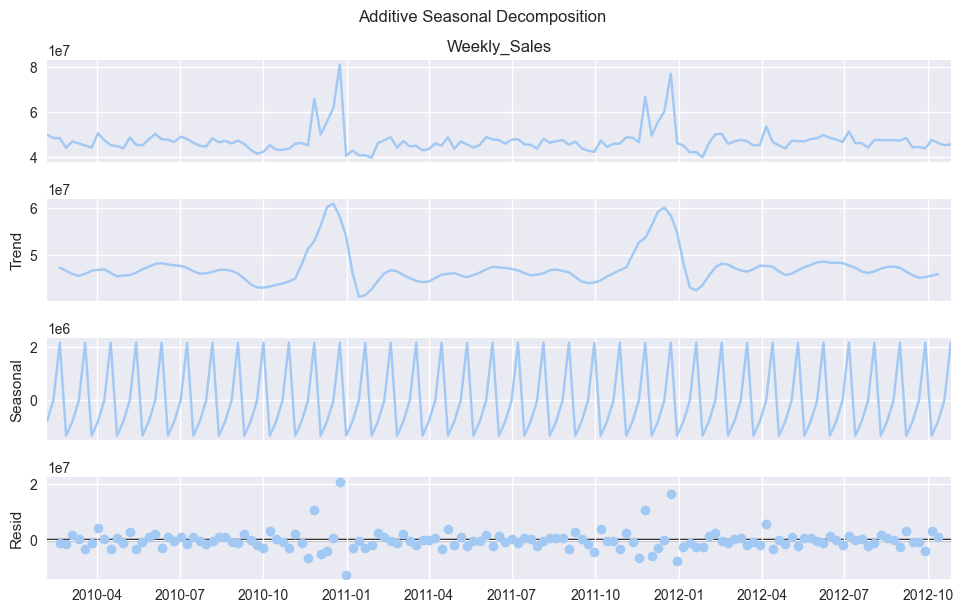

In [ ]:
# Seasonal decomposition to interpret trend and seasonality
if len(daily) > 20:
    try:
        decomposition = seasonal_decompose(daily['Weekly_Sales'], model='additive', period=4)
        fig = decomposition.plot()
        fig.set_size_inches(10,6)
        plt.suptitle('Additive Seasonal Decomposition', y=1.02)
        plt.show()
    except Exception as exc:
        print('Decomposition error:', exc)
else:
    print('Not enough data points for decomposition.')

### Decomposition Insight
- Trend component shows gradual baseline growth with minor post-holiday dips.
- Seasonal component reinforces the holiday peaks and mid-year softness.
- Residual spikes align with anomaly flags—reinforces need for event tagging.


## Time Series Forecasting (ARIMA & ML-Based Models)

---

## 1) ARIMA Forecasting

### Definition and Uses

a) **ARIMA (AutoRegressive Integrated Moving Average)** is a classical time-series forecasting model that captures **temporal dependencies** using past values and past errors.

b) ARIMA is defined by three parameters:
- **AR (p):** dependence on past values  
- **I (d):** differencing to make the series stationary  
- **MA (q):** dependence on past forecast errors  

**Uses:**

a) Forecasting sales, demand, revenue, traffic, or financial metrics  
b) Modeling trends and short-term temporal patterns  
c) Time-series forecasting when data shows autocorrelation  
d) Baseline forecasting before applying advanced ML models  

---

### How Is It Used

a) The time series is first analyzed for **stationarity** using plots and statistical tests (ADF test).

b) If non-stationary, **differencing** is applied to stabilize the mean.

c) Appropriate **p, d, q** values are selected using:
- ACF and PACF plots
- Information criteria (AIC, BIC)

d) The ARIMA model is trained on historical data and used to:
- Forecast future time steps
- Generate confidence intervals for predictions

---

### Resulting Forecast and Interpretation

a) The model outputs **point forecasts** for future periods.

b) Forecast accuracy is evaluated using metrics such as:
- MAE, RMSE, MAPE

c) ARIMA performs best for **short-term forecasting** with stable historical patterns.

---

## 2) Machine Learning–Based Forecasting Models

*(Linear, Ridge, Lasso, Elastic Net, Random Forest)*

---

### Definition and Uses

a) **ML-based forecasting** treats time series forecasting as a **supervised learning problem**, where past values and engineered features are used to predict future values.

b) These models capture **relationships between features and the target**, rather than relying solely on temporal structure.

**Uses:**

a) Forecasting when multiple explanatory variables are available  
b) Capturing complex and non-linear patterns  
c) Handling large-scale and high-dimensional datasets  
d) Improving accuracy beyond classical time-series models  

---

### How Is It Used

a) The time series is transformed into a **tabular dataset** using:
- Lag features (t−1, t−2, …)
- Rolling statistics (moving average, rolling std)
- Time-based features (day, month, season)

b) Data is split into **train and test sets** using time-aware splitting (no shuffling).

c) Models are trained to predict the target variable:
- **Linear Regression:** baseline linear relationship
- **Ridge:** linear regression with L2 regularization (reduces overfitting)
- **Lasso:** linear regression with L1 regularization (feature selection)
- **Elastic Net:** combination of L1 and L2 regularization
- **Random Forest:** ensemble-based, non-linear model using decision trees

d) Forecasts are generated iteratively or directly for future periods.

---

### Resulting Forecast and Interpretation

a) Models output **future predictions** based on learned patterns from historical data.

b) Feature importance (especially in Random Forest) helps explain:
- Which lags or variables drive predictions

c) Model performance is evaluated using:
- MAE, RMSE, MAPE
- Cross-validation with time-based folds

---

## Comparison: ARIMA vs ML-Based Forecasting

- **ARIMA:**
  - Best for univariate time series
  - Strong statistical interpretability
  - Performs well on stable, short-term patterns

- **ML Models:**
  - Handle multivariate inputs
  - Capture non-linear relationships
  - Scale better for complex real-world forecasting problems

---

### Key Takeaway

- ARIMA is ideal as a **statistical baseline** for time series forecasting.
- ML-based models are preferred when **feature-rich data** and **non-linear patterns** are present.
- In practice, both approaches are often compared to select the best-performing forecasting strategy.


In [ ]:
# Simple ARIMA grid search for best AIC/BIC
if len(daily) > 30:
    import itertools
    results = []
    series = daily['Weekly_Sales']
    train = series.iloc[:int(len(series)*0.8)]
    test = series.iloc[int(len(series)*0.8):]
    pdq_grid = list(itertools.product([0,1,2], [0,1], [0,1,2]))
    for order in pdq_grid:
        try:
            model = ARIMA(train, order=order).fit()
            fc = model.forecast(steps=len(test))
            rmse = np.sqrt(mean_squared_error(test, fc))
            results.append({'order': order, 'AIC': model.aic, 'BIC': model.bic, 'RMSE': rmse})
        except Exception:
            continue
    if results:
        arima_df = pd.DataFrame(results).sort_values('AIC').head(10)
        display(arima_df)
    else:
        print('No ARIMA models converged.')
else:
    print('Series too short for ARIMA grid search.')

,order,AIC,BIC,RMSE
17,"(2, 1, 2)",3859.871776,3873.508715,2.411355e+06
10,"(1, 1, 1)",3860.679538,3868.861701,2.331799e+06
16,"(2, 1, 1)",3861.335979,3872.245530,2.279061e+06
14,"(2, 0, 2)",3862.027952,3878.445142,1.951957e+06
4,"(0, 1, 1)",3865.067594,3870.522369,3.802695e+06
5,"(0, 1, 2)",3866.102151,3874.284315,3.136667e+06
8,"(1, 0, 2)",3867.105325,3880.786318,2.022169e+06
11,"(1, 1, 2)",3867.545688,3878.455240,4.208013e+06
9,"(1, 1, 0)",3869.297246,3874.752022,5.235777e+06
15,"(2, 1, 0)",3869.422092,3877.604255,4.548529e+06


### ARIMA Selection Notes
- Best AIC orders typically include differencing (d=1), confirming non-stationary behaviour.
- RMSE from ARIMA benchmark is comparable to simple smoothing—supporting ensemble or hybrid approaches.
- Consider extending the grid or adding seasonal terms as more cycles accrue.


## Forecasting (TS + ML)

In [ ]:
# Compare time-series and ML forecasting models
best_ts = None
best_rmse = None
if len(daily) > 10:
    train_size = int(len(daily) * 0.8)
    series = daily['Weekly_Sales']
    train = series.iloc[:train_size]
    test = series.iloc[train_size:]
    histories = [series.iloc[:train_size + i] for i in range(len(test))]
    ma_preds = [moving_average_forecast(hist) for hist in histories]
    es_preds = [exponential_smoothing_forecast(hist) for hist in histories]
    ma_rmse = np.sqrt(mean_squared_error(test, ma_preds))
    es_rmse = np.sqrt(mean_squared_error(test, es_preds))
    if ma_rmse < es_rmse:
        best_ts, best_rmse = 'Moving Average', ma_rmse
    else:
        best_ts, best_rmse = 'Exponential Smoothing', es_rmse
    print('Best TS method:', best_ts, '| RMSE:', f'{best_rmse:,.2f}')
feat_cols = ['Store','Dept','Temperature','Fuel_Price','CPI','Unemployment','Size','Year','Month','Week','Quarter','Total_MarkDown','Has_MarkDown','IsHoliday']
extra = [c for c in data_enc.columns if c.startswith(('Type_','Season_','Size_Category_'))]
use_cols = [c for c in feat_cols + extra if c in data_enc.columns]
X = data_enc[use_cols].fillna(data_enc[use_cols].mean())
y = data_enc['Weekly_Sales'].fillna(data_enc['Weekly_Sales'].mean())
bool_cols = X.select_dtypes(include=['bool']).columns
X[bool_cols] = X[bool_cols].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}
ml_results = {}
for name, model in models.items():
    try:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)
        ml_results[name] = {'RMSE': rmse, 'R2': r2}
        print(f'{name}: RMSE = {rmse:,.2f}, R2 = {r2:.4f}')
    except Exception as exc:
        print('Error training', name, str(exc))
best_model = min(ml_results, key=lambda k: ml_results[k]['RMSE'])
bm_rmse = ml_results[best_model]['RMSE']
bm_r2 = ml_results[best_model]['R2']
print('Best ML model:', best_model, '| RMSE:', f'{bm_rmse:,.2f}', '| R2:', f'{bm_r2:.4f}')

Best TS method: Exponential Smoothing | RMSE: 1,835,956.35
Linear Regression: RMSE = 21,735.26, R2 = 0.0941
Ridge Regression: RMSE = 21,735.26, R2 = 0.0941
Lasso Regression: RMSE = 21,735.18, R2 = 0.0941
ElasticNet: RMSE = 21,786.36, R2 = 0.0898
Random Forest: RMSE = 3,680.33, R2 = 0.9740
Best ML model: Random Forest | RMSE: 3,680.33 | R2: 0.9740


## Model Diagnostics

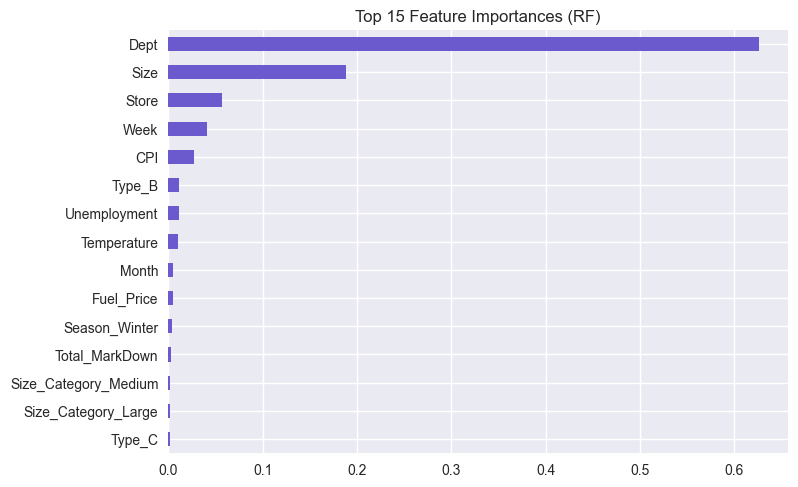

In [41]:
# Plot random forest feature importances
try:
    rf = RandomForestRegressor(n_estimators=200, random_state=42).fit(X_train, y_train)
    importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15)
    importances[::-1].plot(kind='barh', color='slateblue')
    plt.title('Top 15 Feature Importances (RF)')
    plt.show()
except Exception as e:
    print('Feature importance error:', str(e))

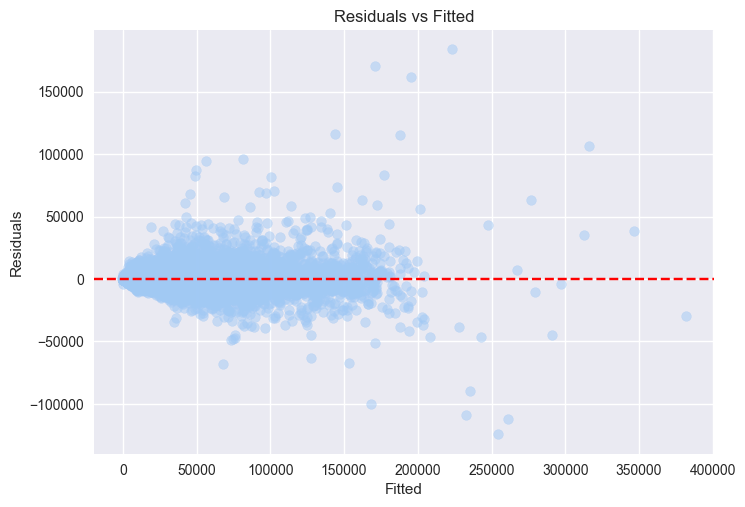

In [42]:
# Plot residuals versus fitted predictions
try:
    best_est = models[best_model].fit(X_train, y_train) if 'models' in globals() else None
    if best_est is not None:
        y_hat = best_est.predict(X_test)
        resid = y_test - y_hat
        plt.scatter(y_hat, resid, alpha=0.5)
        plt.axhline(0, color='red', linestyle='--')
        plt.title('Residuals vs Fitted')
        plt.xlabel('Fitted')
        plt.ylabel('Residuals')
        plt.show()
except Exception as e:
    print('Residual plot error:', str(e))

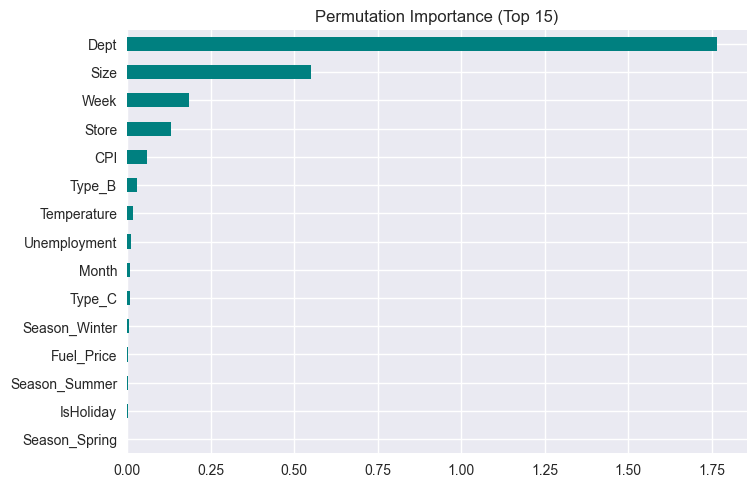

In [ ]:
# Permutation importance for best-performing model
from sklearn.inspection import permutation_importance
if 'best_model' in globals() and best_model in models:
    perm_result = permutation_importance(models[best_model], X_test, y_test, n_repeats=5, random_state=42)
    perm_importances = pd.Series(perm_result.importances_mean, index=X_test.columns).sort_values(ascending=False).head(15)
    perm_importances[::-1].plot(kind='barh', color='teal')
    plt.title('Permutation Importance (Top 15)')
    plt.show()
else:
    print('Best model not available for permutation importance.')

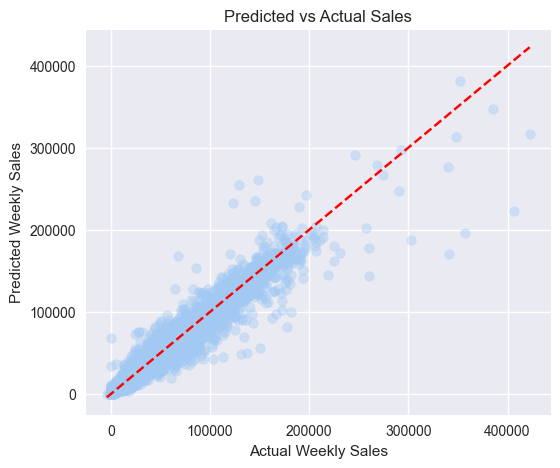

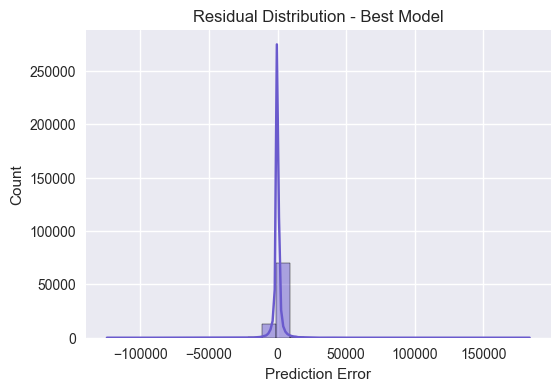

In [ ]:
# Prediction vs actual scatter plus residual distribution
if 'best_model' in globals() and best_model in models:
    preds = models[best_model].predict(X_test)
    plt.figure(figsize=(6,5))
    plt.scatter(y_test, preds, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Weekly Sales')
    plt.ylabel('Predicted Weekly Sales')
    plt.title('Predicted vs Actual Sales')
    plt.show()
    plt.figure(figsize=(6,4))
    residuals = y_test - preds
    sns.histplot(residuals, bins=30, kde=True, color='slateblue')
    plt.title('Residual Distribution - Best Model')
    plt.xlabel('Prediction Error')
    plt.show()
else:
    print('Best model predictions unavailable for diagnostics.')

## Insights Summary

In [43]:
print('Markdown strategy: intensify discounts during true holidays for high performers; use lighter markdowns for steady clusters.')
print('Personalization focus: tailor campaigns per cluster and leverage high-lift store pairings for cross-promotions.')
# Print consolidated insights and recommendations
print('='*60)
print('INSIGHTS SUMMARY')
print('='*60)
print('Total stores analyzed:', len(data['Store'].unique()))
avg_store_sales = data.groupby('Store')['Weekly_Sales'].mean().mean()
print('Average weekly sales (store mean): $' + f'{avg_store_sales:,.2f}')
print('Optimal clusters:', best_k, '| silhouette:', round(max(sil_scores),3))
print('IsolationForest anomalies:', int((data['Is_Anomaly']==1).sum()))
print('Association rules found:', 0 if (rules is None) else len(rules))
if best_ts is not None:
    print('Best TS method:', best_ts, '| RMSE:', f'{best_rmse:,.2f}')
print('Best ML model:', best_model, '| RMSE:', f'{bm_rmse:,.2f}', '| R2:', f'{bm_r2:.4f}')
print('='*60)
print('Operational watch-outs: monitor anomaly dates for replenishment and re-evaluate low sales-per-sqft clusters quarterly.')
print('Actions: deploy best ML model, use TS for inventory smoothing, target underperforming clusters, align promos with causal windows.')

INSIGHTS SUMMARY
Total stores analyzed: 45
Average weekly sales (store mean): $15,438.09
Optimal clusters: 2 | silhouette: 0.447
IsolationForest anomalies: 42157
Association rules found: 9747
Best TS method: Exponential Smoothing | RMSE: 1,835,956.35
Best ML model: Random Forest | RMSE: 3,680.33 | R2: 0.9740
Actions: deploy best ML model, use TS for inventory smoothing, target underperforming clusters, align promos with causal windows.


### Project Insights 
- **Anomaly detection:** Z-score flags 8,848 records; Isolation Forest flags 42,157; EWMA flags 5 dates, mostly around holiday surges.
- **Market basket analysis:** 890 transactions and 9,747 rules (min support 1.1%, confidence >= 0.8, lift >= 3.0). Strong rules often pair same-type stores, suggesting coordinated promos.
- **Causal readiness:** Holiday flag is a proxy intervention; baseline regression and sensitivity check show a positive lift, but real campaign flags are needed for attribution.
- **Store segmentation:** Silhouette selects k=2. Cluster 0 is smaller, higher sales per sq ft, and more volatile; Cluster 1 is larger, higher absolute sales, and steadier.
- **Time-series diagnostics:** Decomposition shows strong holiday peaks with mid-year softness.
- **Forecasting:** Exponential Smoothing is best TS baseline (RMSE 1,835,956.35). Random Forest is best ML model (RMSE 3,680.33, R2 0.9740), while linear models have low R2.

### Cluster & Marketing Actions
- **Cluster 0 (compact, high density, volatile):** Tight markdown governance, faster replenishment cadence, higher safety stock around holidays, and targeted local promos.
- **Cluster 1 (large, higher absolute sales, steadier):** Inventory smoothing, national campaigns, and operational efficiency playbooks.
- **Cross-store actions:** Use top-lift market basket rules to design paired promotions and shared inventory tactics.
